Followings are the interesting questions for understanding better the results of a trained model. 
These questions are addressed in this notebook: 

* Which images are the most confident about being cats or dogs or panda? 
* Which images are the least confident about being cats or dogs or panda? 
* Which images have incorrect predictions in spite of being highly confident? 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import random
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img 
from tensorflow.keras.preprocessing.image import img_to_array
from vis.utils import utils
from vis.visualization import visualize_cam, overlay
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

%matplotlib inline

Using TensorFlow backend.


In [3]:
# configuration parameters 
TEST_DATA_DIR = '/Users/sanchit/Documents/Projects/Datasets/fire_and_smoke_data/test/'
MODEL_PATH = "./models/mobilenetv2_.h5"
TEST_SAMPLES = 430
NUM_CLASSES = 2
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64
LABELS = ["fire", "nofire"]

### Load model

In [4]:
model = load_model(MODEL_PATH)

### Load test data via generator

In [5]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 430 images belonging to 2 classes.


In [6]:
predictions = model.predict_generator(test_generator, steps=TEST_SAMPLES // BATCH_SIZE + 1)

Instructions for updating:
Please use Model.predict, which supports generators.


In [7]:
ground_truth = test_generator.classes
filenames = test_generator.filenames
ground_truth[:10]
predictions[:10]

array([[9.9999464e-01, 5.3166846e-06],
       [9.9999917e-01, 7.9977792e-07],
       [1.0000000e+00, 7.1228610e-09],
       [1.2798278e-01, 8.7201726e-01],
       [9.9814355e-01, 1.8564289e-03],
       [9.5284235e-01, 4.7157619e-02],
       [9.9999750e-01, 2.5518054e-06],
       [1.0000000e+00, 1.1537313e-08],
       [1.0000000e+00, 4.5910991e-13],
       [9.9998653e-01, 1.3494899e-05]], dtype=float32)

In [8]:
predict_results = dict()

for ind, val in enumerate(predictions):
    ind_high_prob = np.argmax(val) # index of the highest prob
    val_high_prob = val[ind_high_prob] # value of that highest prob 
    
    predict_results[ind] = [val_high_prob, ind_high_prob, ground_truth[ind]]

In [9]:
def get_imgs_sorted_probs(predict_results: dict, 
                          is_high_probs: bool, 
                          label: int, 
                          num_res_to_return: int, 
                          is_wrong_preds: bool = False):
    """ get a certain number of images according to highest or lowest probabilities with/without correct results 
        :param predict_results: a dict containing prob results 
        :is_high_probs: if only highest (True) or lowest (False) prob results needs to be returned 
        :label: class label 
        :num_res_to_return: number of images or results to return 
        :is_wrong_preds: if wrong or incorrect prediction results need to be return (True) or not (False)
    """
    # first sort the prediction results 
    sorted_pred_results = [(k, predict_results[k])
                               for k in sorted(predict_results,
                                               key=predict_results.get,
                                               reverse=is_high_probs)]
    
    result = [] 
    for ind, val in enumerate(sorted_pred_results):
        img_ind, [prob, pred_ind, gt_ind] = val
        if pred_ind == label:
            if is_wrong_preds:
                if pred_ind != gt_ind:
                    result.append([img_ind, [prob, pred_ind, gt_ind]])
            else:
                if pred_ind == gt_ind:
                    result.append([img_ind, [prob, pred_ind, gt_ind]])
    return result[:num_res_to_return]

In [10]:
get_imgs_sorted_probs(predict_results, True, 2, 10)

[]

In [11]:
def plot_images(filenames, probs, msg):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
        
    plt.figure(figsize=(20, 15))
    columns = 5
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        ax.set_title("\n\n" + filenames[i].split("/")[-1] + "\n" +
                     "\nProbability: " +
                     str(float("{0:.2f}".format(probs[i]))))
        plt.suptitle(msg, fontsize=20, fontweight='bold')
        plt.axis('off')
        plt.imshow(image)
        
def display(sorted_indices, msg=""):
    list_img_paths = []
    list_probs = []
    for name, value in sorted_indices:
        [prob, pred_ind, gt_ind] = value
        list_img_paths.append(TEST_DATA_DIR + filenames[name])
        list_probs.append(prob)
    plot_images(list_img_paths, list_probs, msg)

### Most confident pictures of fire

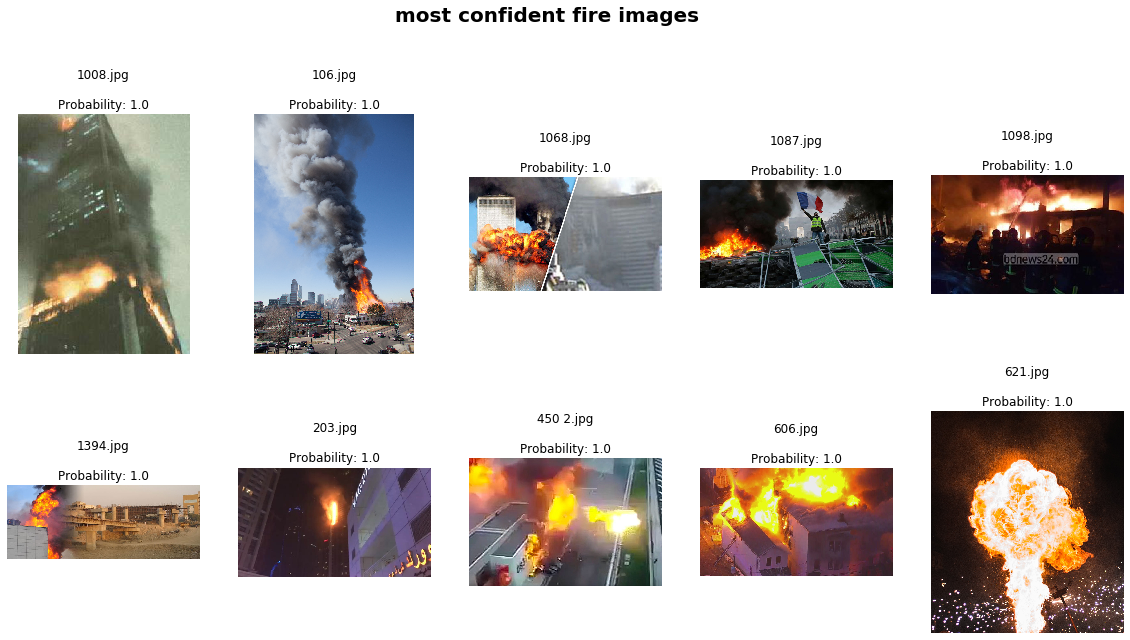

In [12]:
top_confident_cats = get_imgs_sorted_probs(predict_results, True, 0, 10, False)
display(top_confident_cats, msg="most confident fire images")

### Least confident pictures of fire

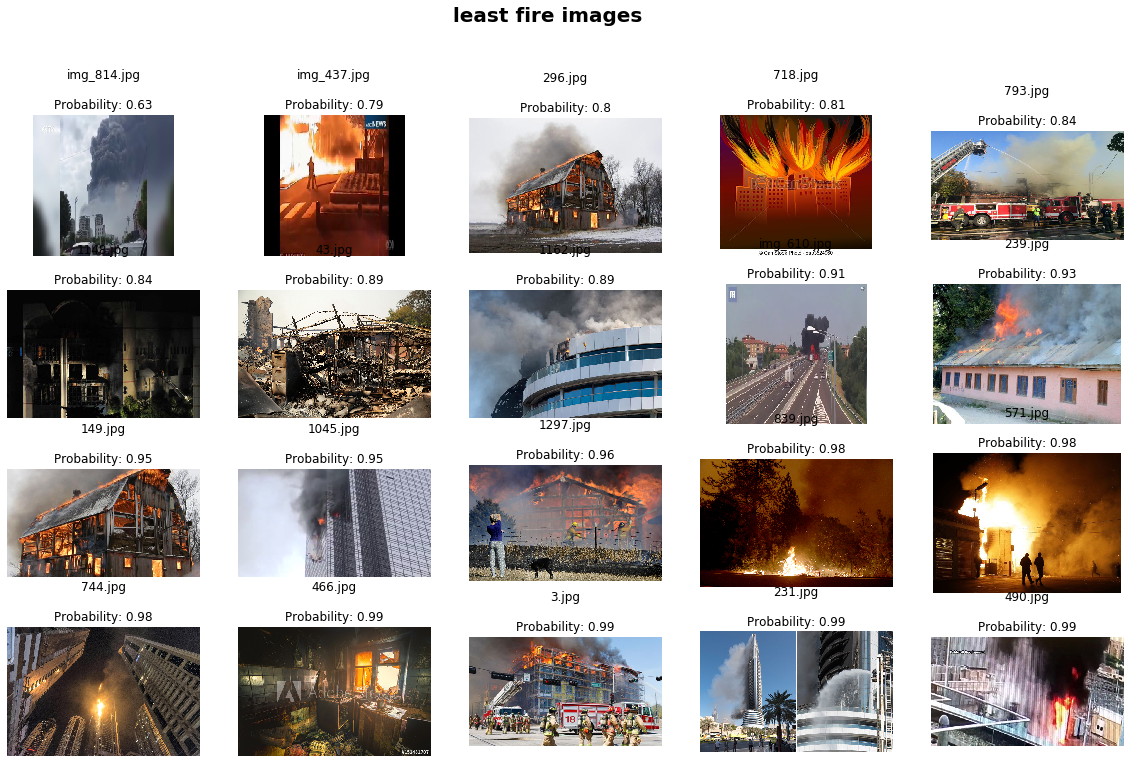

In [13]:
least_confident_cats = get_imgs_sorted_probs(predict_results, False, 0, 20, False)
display(least_confident_cats, msg="least fire images")

### Incorrect predictions of fire

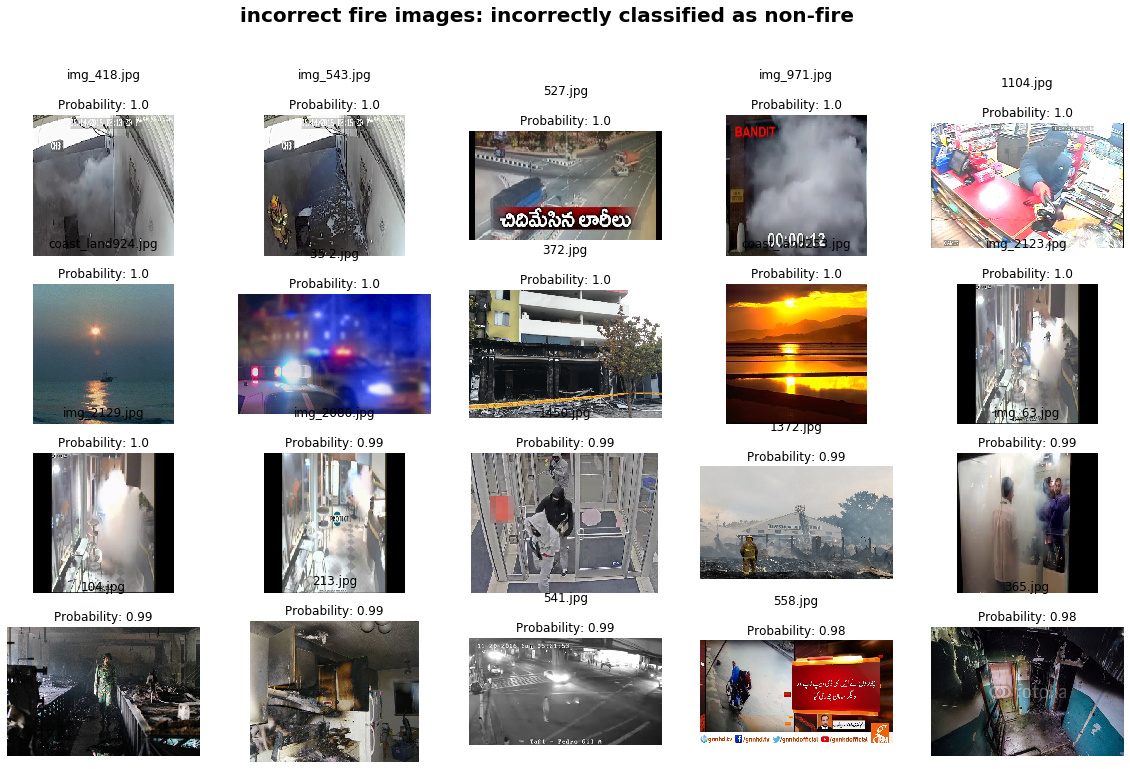

In [14]:
incorrect_cats = get_imgs_sorted_probs(predict_results, True, 0, 20, True)
display(incorrect_cats, msg="incorrect fire images: incorrectly classified as non-fire")

### Most confident images of non-fire 

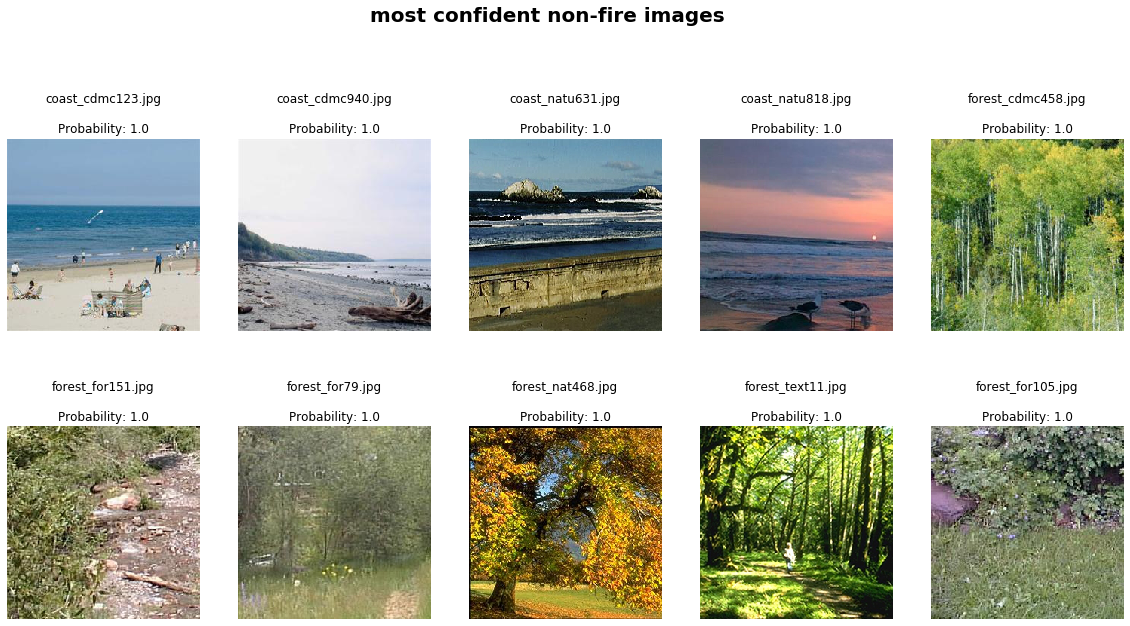

In [15]:
top_confident_dogs = get_imgs_sorted_probs(predict_results, True, 1, 10, False)
display(top_confident_dogs, msg="most confident non-fire images")

### Least confident images of non-fire

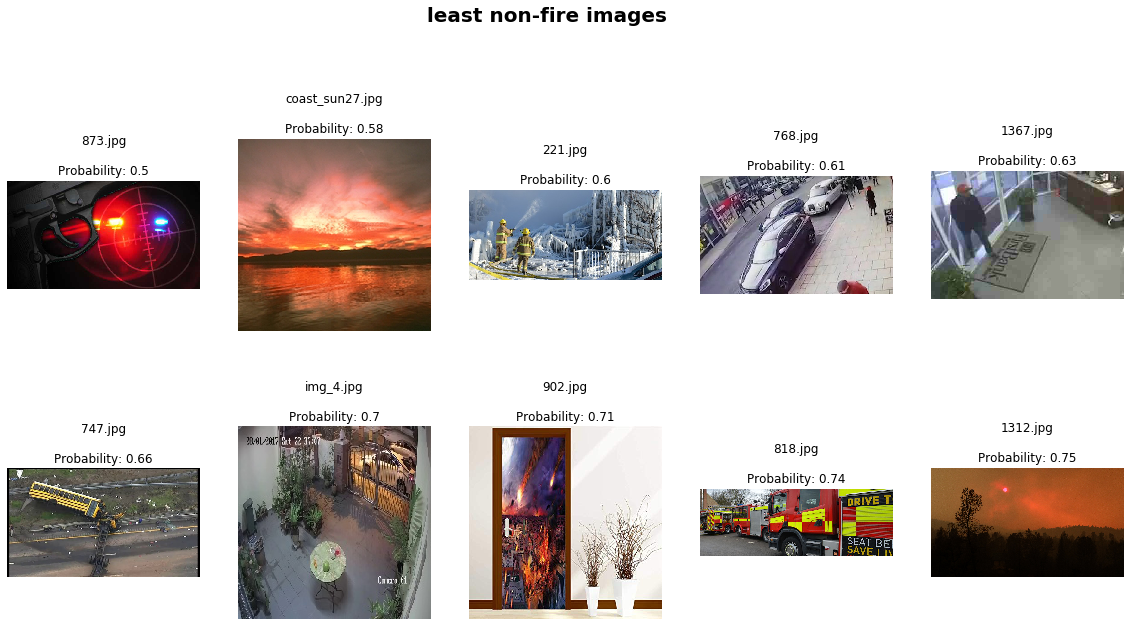

In [16]:
least_confident_dogs = get_imgs_sorted_probs(predict_results, False, 1, 10, False)
display(least_confident_dogs, msg="least non-fire images")

### Incorrent predictions of non-fire

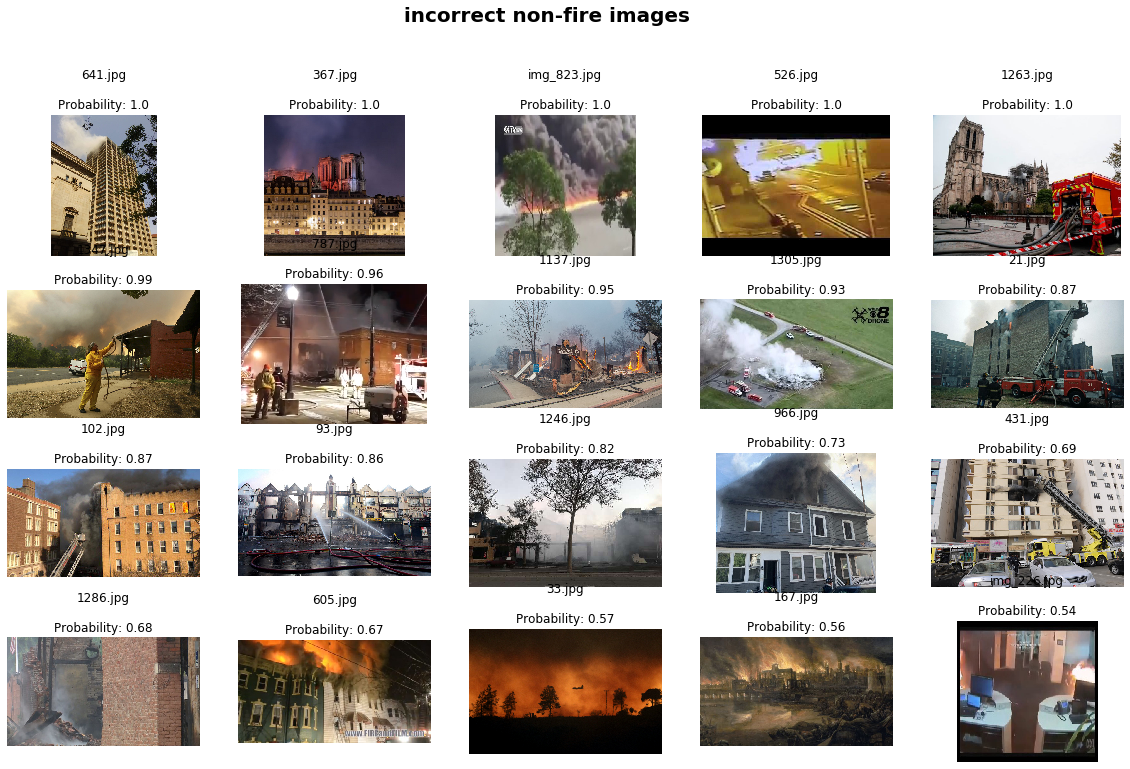

In [17]:
incorrect_dogs = get_imgs_sorted_probs(predict_results, True, 1, 20, True)
display(incorrect_dogs, msg="incorrect non-fire images")